<img src="logos/‎cover‎001.png" alt="Drawing"/>

In [3]:
# imports
import pyxdf
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns

# Load data
Test files with different durations are stored in the folder "data". Before loading them, we want to access their path and save them in a dictionary.

### Task 1:
- Get all files from "data" folder, sort them alphabetically and save them to a variable "files"
Hint: os.listdir()

In [20]:
# get all files from the folder "data"
files = os.listdir("data")
# sort them alphabetically
files.sort()
files

['lsl_test1.xdf', 'lsl_test2.xdf', 'lsl_test3.xdf']

In [21]:
# save all files to an empty dictionary "recordings"
recordings = {}

for i, file in enumerate(files):  # store and display all files
    created = os.path.getmtime(f"data/{file}")  # creation timestamp
    created = datetime.datetime.fromtimestamp(created)  # translate as datetime
    created = created.strftime("%d.%m.%Y %H:%M")  # arrange it
    recordings[i] = {"file": file, "created": created}

files = [f.split(".")[0] for f in files]
# display the recordings and metadata
display(recordings)

{0: {'file': 'lsl_test1.xdf', 'created': '05.08.2022 16:27'},
 1: {'file': 'lsl_test2.xdf', 'created': '05.08.2022 17:09'},
 2: {'file': 'lsl_test3.xdf', 'created': '05.08.2022 17:27'}}

# Extensible Data Format (XDF)

.XDF is a format to store multiple channels of time series data with specific meta information.
For the latency test, we stored 3 streams
- Unity: 'Visual',
- EEG: 'openvibeMarkers', 'openvibeSignal'

The loaded .XDF file results in a list of dictionaries with two main components:

1. **'time_series':** the information sent from Unity and EEG to via LSL
2. **'time_stamps':** the time stamps for each datapoint received

### Task 2:
Load data streams for test 1
Hint: look at [.XDF website info](https://pypi.org/project/pyxdf/)

In [49]:
# load data
streams, _ = pyxdf.load_xdf(f"data/{recordings[0]['file']}")
display(streams)

[{'info': defaultdict(list,
              {'name': ['openvibeMarkers'],
               'type': ['Markers'],
               'channel_count': ['1'],
               'channel_format': ['int32'],
               'source_id': ['(0xb4e83c55, 0xfbc1c4eb)'],
               'nominal_srate': ['0.000000000000000'],
               'version': ['1.100000000000000'],
               'created_at': ['237832.7103915000'],
               'uid': ['8cc5f0ca-0733-4052-9e83-c41e7c935a67'],
               'session_id': ['default'],
               'hostname': ['wd-left'],
               'v4address': [None],
               'v4data_port': ['16573'],
               'v4service_port': ['16573'],
               'v6address': [None],
               'v6data_port': ['16573'],
               'v6service_port': ['16573'],
               'desc': [defaultdict(list,
                            {'channels': [defaultdict(list,
                                          {'channel': [defaultdict(list,
                                

### Accessing streams
Once we load the streams, we can access each list in the dictionary by indicating for example the component we want to access such as stream (an index), 'info', time_stamps or time_series, etc.

For specific information:
- streams[2]['info']['name']

For a particular stream component:
- streams[2]['time_stamps']

For a specific eeg channel
- streams[2]["time_series"][:,64]

In [162]:
# access the second stream's time_stamps
streams[2]['time_stamps']

array([241076.51462992, 241076.51560648, 241076.51658304, ...,
       241805.01170612, 241805.01268268, 241805.01365924])

In [159]:
# print all stream names and index in stream list
s_names = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
s_names

{'openvibeMarkers': 0, 'Visual': 1, 'openvibeSignal': 2}

### Task 3:
Define a function that given the .xdf streams, it returns the relevant streams _Visual_ and _openvibeSignal_

In [68]:
# define a function to select Visual and openvibeSignal from streams
def select_streams(streams):
    # stream names
    u_ch_name = "Visual"
    e_ch_name = "openvibeSignal"

    # get all current streams with their positions on the recording
    # example: {'Diode': 0, 'Audio': 1, 'openvibeSignal': 2}
    s_names = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}

    # store and return their positions
    u = s_names[u_ch_name]  # unity stream channel
    e = s_names[e_ch_name]  # eeg stream channel (photodiode)
    return u, e

In [256]:
# extract streams info for all files
overview_df = pd.DataFrame()
recordings_data_eeg = pd.DataFrame()
recordings_data_unity = pd.DataFrame()

for r in recordings:
    # current filename
    file = recordings[r]["file"]
    # load data
    streams, _ = pyxdf.load_xdf(f"data/{file}")

    # select stream channels
    u_ch, e_ch = select_streams(streams)

    # computer host name
    u_host = streams[u_ch]["info"]["hostname"]
    e_host = streams[e_ch]["info"]["hostname"]

    # select timestamps for each stream
    u_ts = streams[u_ch]["time_stamps"]
    e_ts = streams[e_ch]["time_stamps"]

    # normalize timestamps to start at zero
    u_ts_norm = np.array([u_ts[i] - u_ts[0] for i in range(len(u_ts))])
    e_ts_norm = np.array([e_ts[i] - e_ts[0] for i in range(len(e_ts))])

    # latency of normalized timestamps
    u_latency = np.array([u_ts_norm[i + 1] - u_ts_norm[i] for i in range(len(u_ts_norm) - 1)])
    e_latency = np.array([e_ts_norm[i + 1] - e_ts_norm[i] for i in range(len(e_ts_norm) - 1)])

    # Data from streams
    u_data = streams[u_ch]["time_series"][:,1]
    # eeg only channel 64 where the diode was connected
    e_data = streams[e_ch]["time_series"][:,64]

    # calculate Unity - eeg time difference at start of recording
    # in milliseconds
    diff_ts = (u_ts[0] - e_ts[0]) * 1000

    # calculate recoding duration
    unity_duration =  (u_ts[-1] - u_ts[0]) / 60
    eeg_duration =  (e_ts[-1] - e_ts[0]) / 60

    # calculate sampling rate (FPS)
    unity_sr = 1 / (unity_duration * 60 / len(u_ts))
    eeg_sr = 1 / (eeg_duration * 60 / len(e_ts))

    # Store overview statistics for each test
    overview_df = overview_df.append({"file_name": file,
                          "u_duration": unity_duration,
                          "diff_ts": diff_ts,
                          "eeg_duration": eeg_duration,
                          "u_fps": unity_sr,
                          "eeg_fps": eeg_sr,
                          "u_host": u_host,
                          "eeg_host": e_host}, ignore_index=True)

    # Store key stream for use in analysis
    r_data_eeg = pd.concat([pd.DataFrame(np.resize(file, len(e_ts_norm)), columns=['filename']),
                                pd.DataFrame(e_ts, columns=['e_ts']),
                                pd.DataFrame(e_ts_norm, columns=['e_ts_norm']),
                                pd.DataFrame(e_latency, columns=['e_latency']),
                                pd.DataFrame(e_data, columns=['sensor_data'])], axis=1)

    r_data_unity = pd.concat([pd.DataFrame(np.resize(file, len(u_ts_norm)), columns=['filename']),
                                pd.DataFrame(u_ts, columns=['u_ts']),
                                pd.DataFrame(u_ts_norm, columns=['u_ts_norm']),
                                pd.DataFrame(u_latency, columns=['u_latency']),
                                pd.DataFrame(u_data, columns=['switch_state'])], axis=1)

    recordings_data_eeg = recordings_data_eeg.append(r_data_eeg, ignore_index=True)
    recordings_data_unity = recordings_data_unity.append(r_data_unity, ignore_index=True)

In [257]:
overview_df

,file_name,u_duration,diff_ts,eeg_duration,u_fps,eeg_fps,u_host,eeg_host
0,lsl_test1.xdf,3.916573,202.217769,3.91665,90.006411,1024.004250,[ml03],[wd-left]
1,lsl_test2.xdf,7.316522,195.385762,7.31665,90.001775,1024.002292,[ml03],[wd-left]
2,lsl_test3.xdf,12.141584,290.242177,12.14165,90.001986,1024.001364,[ml03],[wd-left]


In [258]:
recordings_data_unity

,filename,u_ts,u_ts_norm,u_latency,switch_state
0,lsl_test1.xdf,237978.852120,0.000000,0.010958,0.0
1,lsl_test1.xdf,237978.863078,0.010958,0.011143,0.0
2,lsl_test1.xdf,237978.874221,0.022101,0.011073,0.0
3,lsl_test1.xdf,237978.885294,0.033174,0.011390,0.0
4,lsl_test1.xdf,237978.896684,0.044564,0.011006,0.0
...,...,...,...,...,...
126222,lsl_test3.xdf,241805.255518,728.450646,0.011096,1.0
126223,lsl_test3.xdf,241805.266613,728.461741,0.011074,1.0
126224,lsl_test3.xdf,241805.277687,728.472815,0.011127,1.0
126225,lsl_test3.xdf,241805.288814,728.483942,0.011094,1.0


In [259]:
recordings_data_eeg

,filename,e_ts,e_ts_norm,e_latency,sensor_data
0,lsl_test1.xdf,237978.649902,0.000000,0.000977,-960.987854
1,lsl_test1.xdf,237978.650879,0.000977,0.000977,-962.440613
2,lsl_test1.xdf,237978.651855,0.001953,0.000977,-2311.255127
3,lsl_test1.xdf,237978.652832,0.002930,0.000977,-13144.399414
4,lsl_test1.xdf,237978.653809,0.003906,0.000977,-21171.984375
...,...,...,...,...,...
1436155,lsl_test3.xdf,241805.009753,728.495123,0.000977,-1772.869507
1436156,lsl_test3.xdf,241805.010730,728.496100,0.000977,-1065.075195
1436157,lsl_test3.xdf,241805.011706,728.497076,0.000977,-988.388916
1436158,lsl_test3.xdf,241805.012683,728.498053,0.000977,-966.504822


# Tests' descriptive statistic
Now we can calculate the average latency with which each EEG and Unity sample enter the system for each of the recorded tests.

### Task 4:
- Calculate the average latency for each device (EEG, Unity)
- How constant are the frame rates?

In [260]:
# EEG's latency
recordings_data_eeg.groupby('filename')['e_latency'].describe()

,count,mean,std,min,25%,50%,75%,max
filename,,,,,,,,
lsl_test1.xdf,240639.0,0.000977,1.123662e-11,0.000977,0.000977,0.000977,0.000977,0.000977
lsl_test2.xdf,449535.0,0.000977,1.453316e-11,0.000977,0.000977,0.000977,0.000977,0.000977
lsl_test3.xdf,745983.0,0.000977,1.293867e-11,0.000977,0.000977,0.000977,0.000977,0.000977


In [261]:
# Unity's latency
recordings_data_unity.groupby('filename')['u_latency'].describe()

,count,mean,std,min,25%,50%,75%,max
filename,,,,,,,,
lsl_test1.xdf,21150.0,0.011111,0.000722,0.000159,0.011063,0.011104,0.011145,0.022409
lsl_test2.xdf,39509.0,0.011111,0.000757,0.000157,0.011066,0.011105,0.011143,0.022474
lsl_test3.xdf,65565.0,0.011111,0.000734,0.000152,0.011067,0.011104,0.011142,0.022414


How constant are the framerates?
- EEG (1024Hz) each sample ~ 0.98ms.
- Unity (90Hz) each sample ~ 11.11 ms

# Latencies visualization
### Task 5:
- Visualize the latencies distributions for EEG and Unity

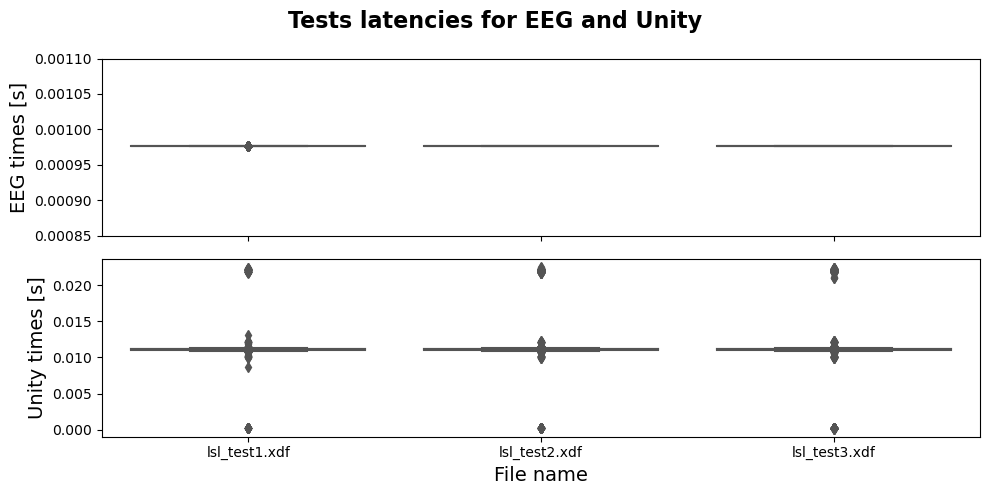

In [262]:
fig, ax = plt.subplots(2,1, figsize=(10, 5), sharex=True)
# set figure title
fig.suptitle("Tests latencies for EEG and Unity", fontsize=16, fontweight='bold')
# plot eeg latencies
sns.boxplot(x="filename", y="e_latency",data=recordings_data_eeg, palette="muted", ax=ax[0])
ax[0].set_xlabel("")
ax[0].set_ylabel("EEG times [s]", fontsize=14)
ax[0].set_ylim(recordings_data_eeg["e_latency"].min(), recordings_data_eeg["e_latency"].max())
ax[0].set_ylim(0.00085, 0.0011)
# plot unity latencies
sns.boxplot(x="filename", y="u_latency",data=recordings_data_unity, palette="muted", ax=ax[1])
ax[1].set_xlabel("File name",fontsize=14)
ax[1].set_ylabel("Unity times [s]", fontsize=14)
plt.tight_layout()
plt.show()

# Markers' visualizations
Now we will visualize the behavior between EEG and Unity for the first 5 seconds of recording in one of the tests.
### Task 6:
- Select test number 3 from the EEG and Unity dataframe and visualize the first 5 seconds of recording

In [263]:
e_start_t3 = recordings_data_eeg[(recordings_data_eeg['filename'] == 'lsl_test3.xdf') &
                                 (recordings_data_eeg['e_ts_norm'] <= 5)]
u_start_t3 = recordings_data_unity[(recordings_data_unity['filename'] == 'lsl_test3.xdf') &
                                 (recordings_data_unity['u_ts_norm'] <= 5)]
u_start_t3

,filename,u_ts,u_ts_norm,u_latency,switch_state
60661,lsl_test3.xdf,241076.804872,0.000000,0.011148,2.0
60662,lsl_test3.xdf,241076.816020,0.011148,0.011092,2.0
60663,lsl_test3.xdf,241076.827112,0.022240,0.011263,2.0
60664,lsl_test3.xdf,241076.838375,0.033503,0.010970,2.0
60665,lsl_test3.xdf,241076.849345,0.044473,0.011096,2.0
...,...,...,...,...,...
61107,lsl_test3.xdf,241081.758225,4.953353,0.011071,2.0
61108,lsl_test3.xdf,241081.769296,4.964424,0.011170,2.0
61109,lsl_test3.xdf,241081.780466,4.975594,0.011056,2.0
61110,lsl_test3.xdf,241081.791522,4.986649,0.011118,2.0


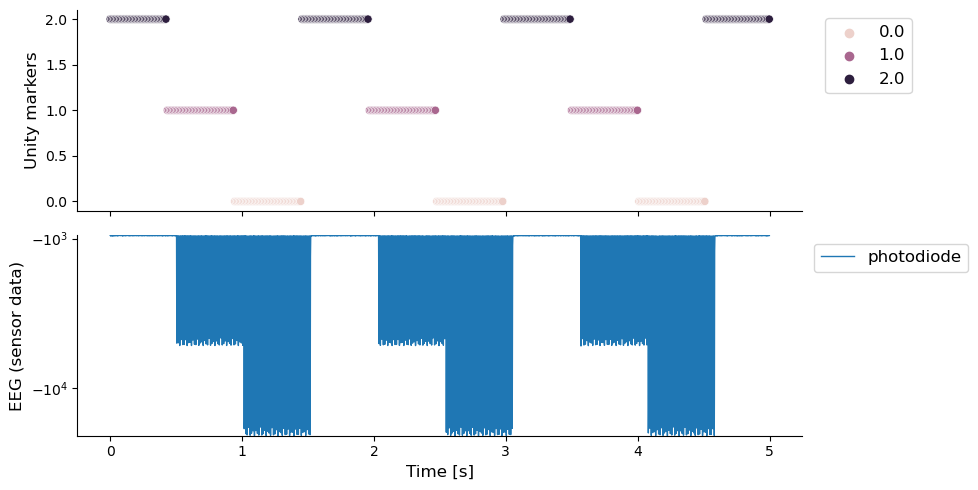

In [269]:
fig, ax = plt.subplots(2,1, figsize=(10, 5), sharex=True)
# plot Unity data
g1 = sns.scatterplot(x="u_ts_norm", y="switch_state",data=u_start_t3, hue="switch_state",ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left',  fontsize=12)
ax[0].set_xlabel("")
ax[0].set_ylabel("Unity markers", fontsize=12)

# # plot EEG data
g2 = sns.lineplot(x="e_ts_norm", y="sensor_data", data=e_start_t3, ax=ax[1], label='photodiode', linewidth=1)
ax[1].set_xlabel("Time [s]", fontsize=12)
ax[1].set_ylabel("EEG (sensor data)", fontsize=12)
ax[1].legend(bbox_to_anchor=(1.24, 1), loc='upper right',  fontsize=12)
ax[1].set_ylim(e_start_t3["sensor_data"].min(), e_start_t3["sensor_data"].max())
plt.yscale("symlog")
sns.despine()
plt.tight_layout()

# Conclusions:
1. EEG sampling rate was extremely constant with each sample latency (mean = ~ 0.98 ms, std = 0.0)
2. Unity sampling rate was somewhat constant with each sample latency (mean = ~ 11.11 ms, std = 0.75 ms)
3. Latencies for both devices were constant independently of recording duration
4. <strong>LSL is a reliable method to collect brain and behavioral data when combining EEG and VR.</strong>